In [1]:
%pip install h5py rtree pygeos --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import h5py

import geopandas as gpd
import geobr

from datetime import datetime

from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [3]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = '10'

In [ ]:
file_path = './1 - Organized data gauge/BRAZIL/BRAZIL_DAILY_1961_2024.h5'
with h5py.File(file_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_data', 'table_info', 'table_metrics']


In [42]:
qc_path = './1 - Organized data gauge/BRAZIL/DATASETS/BRAZIL_DAILY_1961_2024_QC.h5'
with h5py.File(qc_path, 'r') as hdf:
    keys = list(hdf.keys())
    print(keys)

['table_crossvalidation', 'table_data', 'table_grid', 'table_info']


# Data processing

In [5]:
df_data = pd.read_hdf('./1 - Organized data gauge/BRAZIL/BRAZIL_DAILY_1961_2024.h5', key = 'table_data', encoding = 'utf-8')
df_data

,gauge_code,datetime,rain_mm
0,00047000,1961-01-01,0.0
1,00047000,1961-01-02,0.0
2,00047000,1961-01-03,0.0
3,00047000,1961-01-04,0.0
4,00047000,1961-01-05,0.0
...,...,...,...
1076753,S717,2021-12-27,0.0
1076754,S717,2021-12-28,0.0
1076755,S717,2021-12-29,0.0
1076756,S717,2021-12-30,0.0


In [43]:
df_data_qc = pd.read_hdf(qc_path, key = 'table_data', encoding = 'utf-8')
df_data_qc

,gauge_code,datetime,rain_mm,year,final_classif
365,00047000,1962-01-01,0.0,1962,HQ
366,00047000,1962-01-02,0.0,1962,HQ
367,00047000,1962-01-03,0.0,1962,HQ
368,00047000,1962-01-04,0.0,1962,HQ
369,00047000,1962-01-05,0.0,1962,HQ
...,...,...,...,...,...
123612472,S716,2021-12-27,0.0,2021,HQ
123612473,S716,2021-12-28,0.0,2021,HQ
123612474,S716,2021-12-29,0.0,2021,HQ
123612475,S716,2021-12-30,4.4,2021,HQ


In [44]:
df_info_qc = pd.read_hdf(qc_path, key = 'table_info', encoding = 'utf-8')
df_info_qc

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long
18980,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375
18979,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028
18978,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889
18976,NOVA ALVORADA DO SUL | S712,S712,NOVA ALVORADA DO SUL,MATO GROSSO DO SUL,INMET,INMET,MS,-21.450972,-54.341972
18975,LAGUNA CARAPA | S711,S711,LAGUNA CARAPA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.575389,-55.160333
...,...,...,...,...,...,...,...,...,...
4,MARUDA,00047005,MARAPANIM,PARÁ,ANA,HIDROWEB,PA,-0.633600,-47.658300
3,PRIMAVERA,00047004,PRIMAVERA,PARÁ,ANA,HIDROWEB,PA,-0.929400,-47.099400
2,CURUÇA,00047003,CURUÇA,PARÁ,ANA,HIDROWEB,PA,-0.737500,-47.853600
1,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600


In [6]:
gauge_set = set((df_data['gauge_code'].unique()))
len(gauge_set)

18503

In [7]:
def analyze_gauge_activity(df):
    # Ensure datetime is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Group by gauge_code
    grouped = df.groupby('gauge_code')
    
    # Initialize lists to store results
    gauge_codes = []
    num_years_activity = []
    first_dates = []
    last_dates = []
    years_without_gaps = []
    percent_missing_days = []
    percent_years_with_missing_days = []
    
    for gauge_code, group in grouped:
        gauge_codes.append(gauge_code)
        
        # Calculate number of years with activity
        years = group['datetime'].dt.year.unique()
        num_years_activity.append(len(years))
        
        # Calculate first and last date
        first_dates.append(group['datetime'].min())
        last_dates.append(group['datetime'].max())
        
        # Calculate years without gaps
        complete_years = group.set_index('datetime').resample('YE').count()
        complete_years = complete_years[complete_years['rain_mm'] >= 365]
        years_without_gaps.append(len(complete_years))
        
        # Calculate percent of missing days
        total_days = (group['datetime'].max() - group['datetime'].min()).days + 1
        missing_days = total_days - len(group)
        percent_missing_days.append((missing_days / total_days) * 100)
        
        # Calculate percent of years with missing days
        years_with_missing_days = len(years) - len(complete_years)
        percent_years_with_missing_days.append((years_with_missing_days / len(years)) * 100)
    
    # Create result dataframe
    result_df = pd.DataFrame({
        'gauge_code': gauge_codes,
        'num_years_activity': num_years_activity,
        'first_date': first_dates,
        'last_date': last_dates,
        'years_without_gaps': years_without_gaps,
        'percent_missing_days': percent_missing_days,
        'percent_years_with_missing_days': percent_years_with_missing_days
    })
    
    return result_df

# Example usage
df_gauge_analysis = analyze_gauge_activity(df_data)
df_gauge_analysis

,gauge_code,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,00047000,4,1961-01-01,1964-12-31,4,0.0,0.000000
1,00047002,44,1977-12-09,2020-12-31,43,0.0,2.272727
2,00047003,40,1981-07-01,2020-12-31,39,0.0,2.500000
3,00047004,39,1982-02-18,2020-12-31,38,0.0,2.564103
4,00047005,32,1989-08-21,2020-12-31,31,0.0,3.125000
...,...,...,...,...,...,...,...
18498,S713,1,2021-01-01,2021-12-31,1,0.0,0.000000
18499,S714,1,2021-01-01,2021-12-31,1,0.0,0.000000
18500,S715,1,2021-01-01,2021-12-31,1,0.0,0.000000
18501,S716,1,2021-01-01,2021-12-31,1,0.0,0.000000


In [8]:
df_gauge_analysis.to_hdf('./1 - Organized data gauge/BRAZIL/BRAZIL_DAILY_1961_2024.h5', key = 'table_metrics', mode = 'r+', complevel = 9, encoding="utf-8")
df_gauge_analysis

,gauge_code,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,00047000,4,1961-01-01,1964-12-31,4,0.0,0.000000
1,00047002,44,1977-12-09,2020-12-31,43,0.0,2.272727
2,00047003,40,1981-07-01,2020-12-31,39,0.0,2.500000
3,00047004,39,1982-02-18,2020-12-31,38,0.0,2.564103
4,00047005,32,1989-08-21,2020-12-31,31,0.0,3.125000
...,...,...,...,...,...,...,...
18498,S713,1,2021-01-01,2021-12-31,1,0.0,0.000000
18499,S714,1,2021-01-01,2021-12-31,1,0.0,0.000000
18500,S715,1,2021-01-01,2021-12-31,1,0.0,0.000000
18501,S716,1,2021-01-01,2021-12-31,1,0.0,0.000000


In [9]:
df_info = pd.read_hdf('./1 - Organized data gauge/BRAZIL/BRAZIL_DAILY_1961_2024.h5', key = 'table_info', encoding = 'utf-8')
df_info = df_info[df_info['gauge_code'].isin(df_data['gauge_code'].unique())]

df_info

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long
18981,SELVIRIA | S717,S717,SELVIRIA,MATO GROSSO DO SUL,INMET,INMET,MS,-20.351389,-51.430278
18980,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375
18979,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028
18978,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889
18977,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833
...,...,...,...,...,...,...,...,...,...
4,MARUDA,00047005,MARAPANIM,PARÁ,ANA,HIDROWEB,PA,-0.633600,-47.658300
3,PRIMAVERA,00047004,PRIMAVERA,PARÁ,ANA,HIDROWEB,PA,-0.929400,-47.099400
2,CURUÇA,00047003,CURUÇA,PARÁ,ANA,HIDROWEB,PA,-0.737500,-47.853600
1,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600


In [ ]:
# df_lat_long = df_info[df_info['gauge_code'].isin(df_data['gauge_code'].unique())]

# df_lat_long[['gauge_code',	'lat',	'long']].to_excel('./5 - Results/df_lat_long.xlsx', index = False, sheet_name='data')

In [11]:
df_complete_info = pd.merge(df_info, df_gauge_analysis, on='gauge_code', how = 'right')
df_complete_info

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long,num_years_activity,first_date,last_date,years_without_gaps,percent_missing_days,percent_years_with_missing_days
0,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,4,1961-01-01,1964-12-31,4,0.0,0.000000
1,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,44,1977-12-09,2020-12-31,43,0.0,2.272727
2,CURUÇA,00047003,CURUÇA,PARÁ,ANA,HIDROWEB,PA,-0.737500,-47.853600,40,1981-07-01,2020-12-31,39,0.0,2.500000
3,PRIMAVERA,00047004,PRIMAVERA,PARÁ,ANA,HIDROWEB,PA,-0.929400,-47.099400,39,1982-02-18,2020-12-31,38,0.0,2.564103
4,MARUDA,00047005,MARAPANIM,PARÁ,ANA,HIDROWEB,PA,-0.633600,-47.658300,32,1989-08-21,2020-12-31,31,0.0,3.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18498,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,1,2021-01-01,2021-12-31,1,0.0,0.000000
18499,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,1,2021-01-01,2021-12-31,1,0.0,0.000000
18500,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,1,2021-01-01,2021-12-31,1,0.0,0.000000
18501,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,1,2021-01-01,2021-12-31,1,0.0,0.000000


In [12]:
def analyze_gauge_activity_by_year(df):
    # Ensure datetime is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Group by gauge_code and year
    df['year'] = df['datetime'].dt.year
    grouped = df.groupby(['gauge_code', 'year'])
    
    # Initialize lists to store results
    gauge_codes = []
    years = []
    num_days_activity = []
    first_dates = []
    last_dates = []
    percent_missing_days = []
    
    for (gauge_code, year), group in grouped:
        gauge_codes.append(gauge_code)
        years.append(year)
        
        # Calculate number of days with activity
        num_days_activity.append(len(group))
        
        # Calculate first and last date
        first_dates.append(group['datetime'].min())
        last_dates.append(group['datetime'].max())
        
        # Calculate percent of missing days
        total_days = (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1
        missing_days = total_days - len(group)
        percent_missing_days.append((missing_days / total_days) * 100)
    
    # Create result dataframe
    result_df = pd.DataFrame({
        'gauge_code': gauge_codes,
        'year': years,
        'num_days_activity': num_days_activity,
        'first_date': first_dates,
        'last_date': last_dates,
        'percent_missing_days': percent_missing_days
    })
    
    return result_df

# Example usage
df_gauge_analysis_by_year = analyze_gauge_activity_by_year(df_data)
df_gauge_analysis_by_year

,gauge_code,year,num_days_activity,first_date,last_date,percent_missing_days
0,00047000,1961,365,1961-01-01,1961-12-31,0.00000
1,00047000,1962,365,1962-01-01,1962-12-31,0.00000
2,00047000,1963,365,1963-01-01,1963-12-31,0.00000
3,00047000,1964,366,1964-01-01,1964-12-31,0.00000
4,00047002,1977,23,1977-12-09,1977-12-31,93.69863
...,...,...,...,...,...,...
346024,S713,2021,365,2021-01-01,2021-12-31,0.00000
346025,S714,2021,365,2021-01-01,2021-12-31,0.00000
346026,S715,2021,365,2021-01-01,2021-12-31,0.00000
346027,S716,2021,365,2021-01-01,2021-12-31,0.00000


In [13]:
df_complete_info_by_year = pd.merge(df_info,df_gauge_analysis_by_year, on='gauge_code')
df_complete_info_by_year

,name_station,gauge_code,city,state,responsible,source,state_abbreviation,lat,long,year,num_days_activity,first_date,last_date,percent_missing_days
0,SELVIRIA | S717,S717,SELVIRIA,MATO GROSSO DO SUL,INMET,INMET,MS,-20.351389,-51.430278,2021,365,2021-01-01,2021-12-31,0.0
1,SANTA RITA DO PARDO | S716,S716,SANTA RITA DO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-21.305889,-52.820375,2021,365,2021-01-01,2021-12-31,0.0
2,RIBAS DO RIO PARDO | S715,S715,RIBAS DO RIO PARDO,MATO GROSSO DO SUL,INMET,INMET,MS,-20.466694,-53.763028,2021,365,2021-01-01,2021-12-31,0.0
3,PEDRO GOMES | S714,S714,PEDRO GOMES,MATO GROSSO DO SUL,INMET,INMET,MS,-18.072778,-54.548889,2021,365,2021-01-01,2021-12-31,0.0
4,NOVA ANDRADINA | S713,S713,NOVA ANDRADINA,MATO GROSSO DO SUL,INMET,INMET,MS,-22.078611,-53.465833,2021,365,2021-01-01,2021-12-31,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345863,SALINÓPOLIS,00047002,SALINÓPOLIS,PARÁ,ANA,HIDROWEB,PA,-0.623100,-47.353600,2020,366,2020-01-01,2020-12-31,0.0
345864,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1961,365,1961-01-01,1961-12-31,0.0
345865,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1962,365,1962-01-01,1962-12-31,0.0
345866,SALINÓPOLIS,00047000,SALINÓPOLIS,PARÁ,INMET,HIDROWEB,PA,-0.650000,-47.550000,1963,365,1963-01-01,1963-12-31,0.0


# Basins

In [14]:
gdf = gpd.read_file("./shp/meso_RH.shp") 
gdf.sort_values(['nm_mesoRH'], inplace = True)
gdf

,fid,id,cd_mesoRH,nm_mesoRH,cd_macroRH,nm_macroRH,area,geometry
45,46.0,21,11254,Alto Paraguai,112,PARAGUAI,188965.046351,"POLYGON ((-53.68861 -16.85462, -53.68788 -16.8..."
11,12.0,282,10420,Alto Parnaíba,104,PARNAÍBA,137081.887020,"POLYGON ((-43.47870 -6.83663, -43.47662 -6.837..."
38,39.0,205,10629,Alto São Francisco,106,SÃO FRANCISCO,99460.464209,"POLYGON ((-43.68320 -20.42876, -43.68314 -20.4..."
22,23.0,71,10213,Alto Tocantins,102,TOCANTINS-ARAGUAIA,306206.801537,"POLYGON ((-49.35451 -13.57890, -49.35448 -13.5..."
0,1.0,158,11045,Alto Uruguai,110,URUGUAI,76620.958014,"POLYGON ((-49.70906 -28.62592, -49.70998 -28.6..."
21,22.0,67,10214,Araguaia,102,TOCANTINS-ARAGUAIA,384227.860525,"POLYGON ((-52.84597 -17.70442, -52.84598 -17.7..."
17,18.0,279,10418,Baixo Parnaíba,104,PARNAÍBA,48132.423771,"POLYGON ((-40.84847 -3.94569, -40.84843 -3.946..."
41,42.0,219,10626,Baixo São Francisco,106,SÃO FRANCISCO,25254.922911,"POLYGON ((-36.74904 -9.16875, -36.74905 -9.169..."
19,20.0,69,10212,Baixo Tocantins,102,TOCANTINS-ARAGUAIA,247677.770583,"POLYGON ((-48.69901 -6.17903, -48.69854 -6.179..."
31,32.0,28,10732,Contas,107,ATLÂNTICO LESTE,64678.503197,"POLYGON ((-39.01798 -14.41917, -39.01843 -14.4..."


<Axes: >

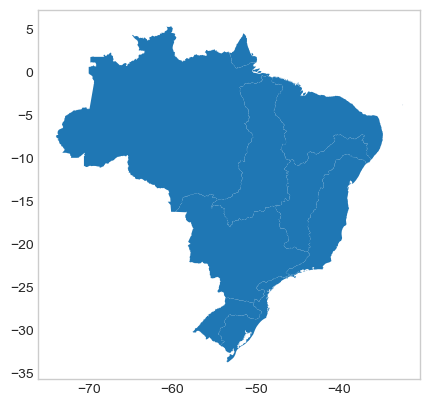

In [15]:
# Combine with the rest of the data
gdf_merged = gpd.GeoDataFrame(
    pd.concat([
        gdf[gdf['fid'].isin([20, 22, 23])].dissolve() # TOCANTINS
        , gdf[gdf['fid'].isin([1, 52])].dissolve() # URUGUAY 
        , gdf[gdf['fid'].isin([42,37,36,39])].dissolve() # SAO FRANCISCO
        , gdf[gdf['fid'].isin([11, 17, 16,19,18,12,13,14,15,41,40,43])].dissolve() # NORTH ATLANTIC REGION
        , gdf[gdf['fid'].isin([30,31,29,28,34,35,32,33,38])].dissolve() # CENTRAL ATLANTIC REGION
        , gdf[gdf['fid'].isin([4,53,5,2,3])].dissolve() # SOUTH ATLANTIC REGION
        , gdf[gdf['fid'].isin([6,7,8,9,10,21,24,25,26,27])].dissolve() # AMAZON RIVER
        , gdf[gdf['fid'].isin([44,45,46,47,48,49,50,51,54])].dissolve() # PARANA RIVER
    ]),
    crs=gdf.crs
)

# Optional: Reset index
gdf_merged = gdf_merged.reset_index(drop=True)
gdf_merged.plot()

In [16]:
gdf_merged

,geometry,fid,id,cd_mesoRH,nm_mesoRH,cd_macroRH,nm_macroRH,area
0,"POLYGON ((-52.84598 -17.70437, -52.84601 -17.7...",23.0,71,10213,Alto Tocantins,102,TOCANTINS-ARAGUAIA,306206.801537
1,"POLYGON ((-54.45210 -31.64075, -54.45193 -31.6...",1.0,158,11045,Alto Uruguai,110,URUGUAI,76620.958014
2,"POLYGON ((-43.68262 -20.43002, -43.68281 -20.4...",39.0,205,10629,Alto São Francisco,106,SÃO FRANCISCO,99460.464209
3,"MULTIPOLYGON (((-43.45876 -9.22555, -43.45940 ...",12.0,282,10420,Alto Parnaíba,104,PARNAÍBA,137081.887020
4,"MULTIPOLYGON (((-44.21522 -23.09143, -44.21484...",32.0,28,10732,Contas,107,ATLÂNTICO LESTE,64678.503197
5,"MULTIPOLYGON (((-53.74671 -32.08401, -53.74745...",53.0,83,10943,Jacuí,109,ATLÂNTICO SUL,84850.732505
6,"MULTIPOLYGON (((-60.45125 -13.88272, -60.45185...",10.0,136,10102,Foz do Amazonas,101,AMAZÔNICA,74369.340834
7,"POLYGON ((-50.25757 -26.85121, -50.25831 -26.8...",46.0,21,11254,Alto Paraguai,112,PARAGUAI,188965.046351


In [17]:
gdf_macroRH = gdf_merged.drop(columns=['fid', 'id', 'cd_mesoRH', 'nm_mesoRH', 'area'])

gdf_macroRH.loc[
    (gdf_merged['cd_macroRH'] == '112') & (gdf_merged['nm_macroRH'] == 'PARAGUAI'),
    ['cd_macroRH', 'nm_macroRH']
] = ['111', 'Parana river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'TOCANTINS-ARAGUAIA'),
    ['nm_macroRH']
] = ['Tocantins river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'URUGUAI'),
    ['nm_macroRH']
] = ['Uruguay river']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'SÃO FRANCISCO'),
    ['nm_macroRH']
] = ['Sao Francisco river']

gdf_macroRH.loc[
    (gdf_merged['cd_macroRH'] == '104') & (gdf_merged['nm_macroRH'] == 'PARNAÍBA'),
    ['cd_macroRH', 'nm_macroRH']
] = ['105', 'North Atlantic region']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'ATLÂNTICO LESTE'),
    ['nm_macroRH']
] = ['Central Atlantic region']


gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'ATLÂNTICO SUL'),
    ['nm_macroRH']
] = ['South Atlantic region']

gdf_macroRH.loc[
    (gdf_merged['nm_macroRH'] == 'AMAZÔNICA'),
    ['nm_macroRH']
] = ['Amazon river']

gdf_macroRH.sort_values(['cd_macroRH'], inplace = True)
gdf_macroRH

,geometry,cd_macroRH,nm_macroRH
6,"MULTIPOLYGON (((-60.45125 -13.88272, -60.45185...",101,Amazon river
0,"POLYGON ((-52.84598 -17.70437, -52.84601 -17.7...",102,Tocantins river
3,"MULTIPOLYGON (((-43.45876 -9.22555, -43.45940 ...",105,North Atlantic region
2,"POLYGON ((-43.68262 -20.43002, -43.68281 -20.4...",106,Sao Francisco river
4,"MULTIPOLYGON (((-44.21522 -23.09143, -44.21484...",107,Central Atlantic region
5,"MULTIPOLYGON (((-53.74671 -32.08401, -53.74745...",109,South Atlantic region
1,"POLYGON ((-54.45210 -31.64075, -54.45193 -31.6...",110,Uruguay river
7,"POLYGON ((-50.25757 -26.85121, -50.25831 -26.8...",111,Parana river


In [18]:
# Calculate area in square meters
gdf_macroRH = gdf_macroRH.to_crs(epsg=31982) 

gdf_macroRH['area_km2'] = gdf_macroRH.geometry.area * 10000 * (8.51/8.695357)

# Convert to square kilometers (optional)
gdf_macroRH['area_km2_10e6'] = gdf_macroRH['area_km2'] / 1_000_000

print(gdf_macroRH['area_km2'].sum())

gdf_macroRH


8.51041705161437e+16


,geometry,cd_macroRH,nm_macroRH,area_km2,area_km2_10e6
6,"MULTIPOLYGON (((-525311.528 8444817.561, -5253...",101,Amazon river,3.808733e+16,3.808733e+10
0,"POLYGON ((304228.481 8041561.736, 304225.799 8...",102,Tocantins river,9.188692e+15,9.188692e+09
3,"MULTIPOLYGON (((1330661.303 8971409.235, 13305...",105,North Atlantic region,9.759384e+15,9.759384e+09
2,"POLYGON ((1264919.499 7723816.993, 1264895.412...",106,Sao Francisco river,6.336519e+15,6.336519e+09
4,"MULTIPOLYGON (((1195979.470 7430145.166, 11960...",107,Central Atlantic region,5.747668e+15,5.747668e+09
5,"MULTIPOLYGON (((240752.194 6446950.380, 240680...",109,South Atlantic region,2.106535e+15,2.106535e+09
1,"POLYGON ((172575.839 6494204.575, 172591.795 6...",110,Uruguay river,1.709649e+15,1.709649e+09
7,"POLYGON ((573758.500 7029828.614, 573685.502 7...",111,Parana river,1.216839e+16,1.216839e+10


In [19]:
# Step 1: Convert df_info to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_info['long'], df_info['lat'])]
gdf_info = gpd.GeoDataFrame(df_info, geometry=geometry, crs="EPSG:4326")  # Assuming lat/long is in WGS84

# Reproject to match gdf_macroRH's CRS (if necessary)
gdf_info = gdf_info.to_crs(gdf_macroRH.crs)

# Step 2: Perform a spatial join
gdf_basin = gpd.sjoin(gdf_info, gdf_macroRH[['geometry', 'nm_macroRH']], how='left', predicate='within')

# Drop unnecessary columns (e.g., index_right)
gdf_basin = gdf_basin.drop(columns=['index_right'])

In [45]:
# Step 1: Convert df_info to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_info_qc['long'], df_info_qc['lat'])]
gdf_info_qc = gpd.GeoDataFrame(df_info_qc, geometry=geometry, crs="EPSG:4326")  # Assuming lat/long is in WGS84

# Reproject to match gdf_macroRH's CRS (if necessary)
gdf_info_qc = gdf_info_qc.to_crs(gdf_macroRH.crs)

# Step 2: Perform a spatial join
gdf_basin_qc = gpd.sjoin(gdf_info_qc, gdf_macroRH[['geometry', 'nm_macroRH']], how='left', predicate='within')

# Drop unnecessary columns (e.g., index_right)
gdf_basin_qc = gdf_basin_qc.drop(columns=['index_right'])

In [ ]:
gdf_basin = gdf_basin[['gauge_code', 'state', 'nm_macroRH']]
gdf_basin

,gauge_code,state,nm_macroRH
18981,S717,MATO GROSSO DO SUL,Parana river
18980,S716,MATO GROSSO DO SUL,Parana river
18979,S715,MATO GROSSO DO SUL,Parana river
18978,S714,MATO GROSSO DO SUL,Parana river
18977,S713,MATO GROSSO DO SUL,Parana river
...,...,...,...
4,00047005,PARÁ,North Atlantic region
3,00047004,PARÁ,North Atlantic region
2,00047003,PARÁ,North Atlantic region
1,00047002,PARÁ,North Atlantic region


In [46]:
gdf_basin_qc = gdf_basin_qc[['gauge_code', 'state', 'nm_macroRH']]
gdf_basin_qc

,gauge_code,state,nm_macroRH
18980,S716,MATO GROSSO DO SUL,Parana river
18979,S715,MATO GROSSO DO SUL,Parana river
18978,S714,MATO GROSSO DO SUL,Parana river
18976,S712,MATO GROSSO DO SUL,Parana river
18975,S711,MATO GROSSO DO SUL,Parana river
...,...,...,...
4,00047005,PARÁ,North Atlantic region
3,00047004,PARÁ,North Atlantic region
2,00047003,PARÁ,North Atlantic region
1,00047002,PARÁ,North Atlantic region


# Numerical Analysis

In [21]:
# Assuming df_data is already loaded with columns: gauge_code, datetime, rain_mm

df_data['datetime'] = pd.to_datetime(df_data['datetime'])
df_data['year'] = df_data['datetime'].dt.year

# Aggregate rain_mm by gauge_code and year
agg_data = df_data.groupby(['gauge_code', 'year'])['rain_mm'].sum().reset_index()

# Pivot to create a heatmap-compatible DataFrame
heatmap_data = agg_data.pivot(index='gauge_code', columns='year', values='rain_mm').fillna(0)
heatmap_data.columns = heatmap_data.columns.astype(str)  

heatmap_data.reset_index(inplace=True)

heatmap_data.columns = heatmap_data.columns.get_level_values(0)
heatmap_data.columns.name = None
heatmap_data.sort_values(['gauge_code'], ascending=False, inplace = True)
heatmap_data = heatmap_data.drop(columns=['gauge_code'])
heatmap_data[heatmap_data > 0] = 1
heatmap_data

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
18502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [47]:
# Assuming df_data_qc is already loaded with columns: gauge_code, datetime, rain_mm

df_data_qc['datetime'] = pd.to_datetime(df_data_qc['datetime'])
df_data_qc['year'] = df_data_qc['datetime'].dt.year

# Aggregate rain_mm by gauge_code and year
agg_data_qc = df_data_qc.groupby(['gauge_code', 'year'])['rain_mm'].sum().reset_index()

# Pivot to create a heatmap-compatible DataFrame
heatmap_data_qc = agg_data_qc.pivot(index='gauge_code', columns='year', values='rain_mm').fillna(0)
heatmap_data_qc.columns = heatmap_data_qc.columns.astype(str)  

heatmap_data_qc.reset_index(inplace=True)

heatmap_data_qc.columns = heatmap_data_qc.columns.get_level_values(0)
heatmap_data_qc.columns.name = None
heatmap_data_qc.sort_values(['gauge_code'], ascending=False, inplace = True)
heatmap_data_qc = heatmap_data_qc.drop(columns=['gauge_code'])
heatmap_data_qc[heatmap_data_qc > 0] = 1
heatmap_data_qc

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
17187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [22]:
column_sums = heatmap_data.sum()

# Step 2: Pivot columns to rows
result = column_sums.reset_index()
result.columns = ['year', 'active_gauges']
result['active_gauges'] = result['active_gauges'].astype(int)
result

,year,active_gauges
0,1961,3322
1,1962,3952
2,1963,4267
3,1964,4462
4,1965,4521
...,...,...
59,2020,3357
60,2021,5830
61,2022,6152
62,2023,6126


In [48]:
column_sums_qc = heatmap_data_qc.sum()

# Step 2: Pivot columns to rows
result_qc = column_sums_qc.reset_index()
result_qc.columns = ['year', 'active_gauges']
result_qc['active_gauges'] = result_qc['active_gauges'].astype(int)
result_qc

,year,active_gauges
0,1961,2993
1,1962,3235
2,1963,3761
3,1964,3997
4,1965,4099
...,...,...
59,2020,2764
60,2021,4754
61,2022,5116
62,2023,5186


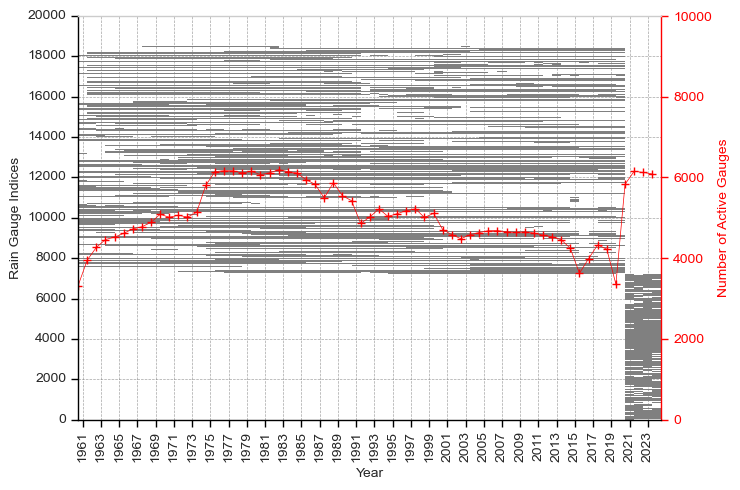

In [23]:
# Create a custom colormap: 0 → white, 1 → black
cmap = mcolors.ListedColormap(['white', 'grey'])
cmap.set_over('white')  # Values >1 will also be white

# Create figure and axis
fig, ax = plt.subplots(figsize=(7.5, 5))


# Plot the heatmap
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    vmin=0,       # Values start at 0
    vmax=1,       # Values up to 1 use the colormap
    linewidths=0, # No grid lines
    linecolor='white',
    cbar=False,   # Hide colorbar (optional)
    ax=ax         # Use the axis object
)

# Customize labels and titles
# ax.set_title('Heatmap: 0 (White) and 1 (Black)')
ax.set_xlabel('Year')
ax.set_ylabel('Rain Gauge Indices')
ax.set_ylim(0, 20000)
ax.tick_params(
    axis='x',          # Apply to x-axis
    which='both',      # Apply to both major and minor ticks
    length=5,          # Length of the ticks
    width=1,           # Width of the ticks
    color='black',     # Color of the ticks     # Font size of tick labels
    bottom=True,       # Show ticks on the bottom
    top=False
)

ax.tick_params(
    axis='y',          # Apply to x-axis
    which='both',      # Apply to both major and minor ticks
    left=True,       # Show ticks on the bottom
    right=False,          # Hide ticks on the top
    labelleft = True,
    labelright = False,
    length=5,          # Length of the ticks
    width=1,           # Width of the ticks
    color='black'
)
ax.set_yticks(np.arange(0, 20001, 2000))
ax.set_yticklabels(np.arange(0, 20001, 2000), rotation = 0)

# # Add a horizontal line to mark the x-axis (e.g., at y=0)
# ax.axhline(
#     y=-1,                  # Position of the line (y=0)
#     color='black',          # Line color
#     linestyle='-',       # Line style
#     linewidth=2,          # Line width
#     alpha=0.7             # Transparency
# )

ax2 = ax.twinx() 

ax2.plot(
    result['year'],          # X-axis: year
    result['active_gauges'], # Y-axis: active_gauges
    color='red',              # Line color
    marker='+',                 # Marker style
    linestyle='-',              # Line style
    linewidth=0.5,                # Line width
    label='Active Gauges'
)

ax2.set_ylabel('Number of Active Gauges', color = 'red')
ax2.set_ylim(0, 10000)
ax2.tick_params(axis='y', labelcolor='red')
ax2.spines.right.set_position(('axes', 1.00001)) 


ax2.tick_params(
    axis='y',          # Apply to x-axis
    which='both',      # Apply to both major and minor ticks
    left=False,       # Show ticks on the bottom
    right=True,          # Hide ticks on the top
    labelleft = False,
    length=5,          # Length of the ticks
    width=1,           # Width of the ticks
    color='red'
) # Ensure proper spacing for third axis


ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')  # Left spine (y-axis) red


ax2.spines['right'].set_color('red')  # Left spine (y-axis) red
ax2.yaxis.label.set_color('red')  

ax.set_axisbelow(False)
ax.grid(True, axis='both', which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)



# Show the plot
plt.tight_layout()
plt.savefig('./figures/active_stations_per_year_versus_completeness.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [50]:
result[['year', 'active_gauges']].tail(35)

,year,active_gauges
29,1990,5546
30,1991,5425
31,1992,4861
32,1993,5019
33,1994,5221
34,1995,5035
35,1996,5103
36,1997,5177
37,1998,5223
38,1999,5009


In [ ]:
result['active_gauges'].max()

5895

In [26]:
df_basis = pd.merge(agg_data[['gauge_code', 'year']], gdf_basin[['gauge_code', 'nm_macroRH']], on = 'gauge_code', how = 'left')
df_basis

,gauge_code,year,nm_macroRH
0,00047000,1961,North Atlantic region
1,00047000,1962,North Atlantic region
2,00047000,1963,North Atlantic region
3,00047000,1964,North Atlantic region
4,00047002,1977,North Atlantic region
...,...,...,...
346024,S713,2021,Parana river
346025,S714,2021,Parana river
346026,S715,2021,Parana river
346027,S716,2021,Parana river


In [52]:
df_basis_qc = pd.merge(agg_data_qc[['gauge_code', 'year']], gdf_basin_qc[['gauge_code', 'nm_macroRH']], on = 'gauge_code', how = 'left')
df_basis_qc

,gauge_code,year,nm_macroRH
0,00047000,1962,North Atlantic region
1,00047000,1963,North Atlantic region
2,00047000,1964,North Atlantic region
3,00047002,1978,North Atlantic region
4,00047002,1979,North Atlantic region
...,...,...,...
294175,S711,2021,Parana river
294176,S712,2021,Parana river
294177,S714,2021,Parana river
294178,S715,2021,Parana river


In [53]:
# Aggregate data
df_grouped_qc = df_basis_qc.groupby(['year', 'nm_macroRH'])['gauge_code'].count().reset_index(name='count')

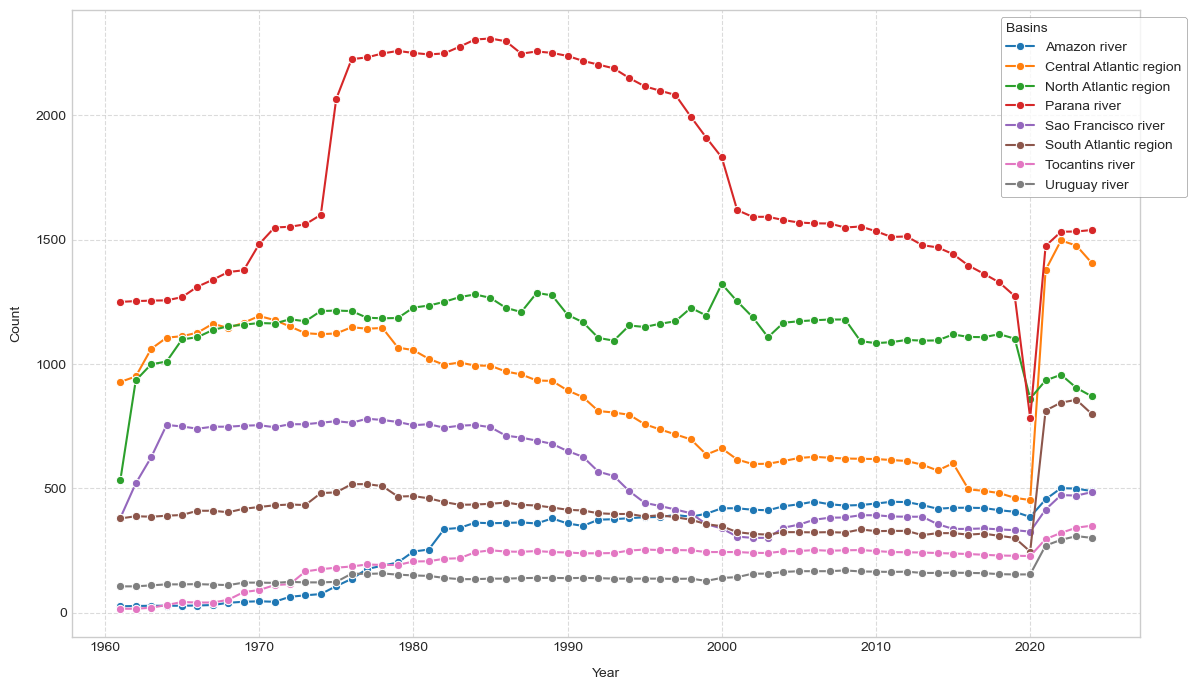

In [40]:
# Aggregate data
df_grouped = df_basis.groupby(['year', 'nm_macroRH'])['gauge_code'].count().reset_index(name='count')

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Plot using seaborn
sns.lineplot(
    data=df_grouped,
    x='year',
    y='count',
    hue='nm_macroRH',
    marker='o',
    palette='tab10',
    ax=ax
)

# Customize the existing legend
legend = ax.get_legend()
if legend:  # Check if legend exists
    # Modify legend properties
    legend.set_title('Basins')
    legend.set_frame_on(True)
    
    # Adjust legend position
    legend._legend_box.align = "left"
    legend.set_bbox_to_anchor((1.05, 1))  # Position outside to the right
    
    # Customize frame appearance
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('grey')
    frame.set_linewidth(0.5)
else:
    # Create legend if it doesn't exist (safety check)
    ax.legend(title='Basins', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and styling
# ax.set_title('Count of Gauge Codes by Year and Region', pad=20)
ax.set_xlabel('Year', labelpad=10)
ax.set_ylabel('Count', labelpad=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to accommodate external legend
plt.tight_layout(rect=[0, 0, 1, 1])  # Make space for right-side legend
plt.show()

In [29]:
df_grouped_amazon = df_grouped[df_grouped['nm_macroRH'] == 'Amazon river']
df_grouped_amazon

,year,nm_macroRH,count
0,1961,Amazon river,26
8,1962,Amazon river,27
16,1963,Amazon river,28
24,1964,Amazon river,28
32,1965,Amazon river,28
...,...,...,...
472,2020,Amazon river,385
480,2021,Amazon river,456
488,2022,Amazon river,501
496,2023,Amazon river,499


In [54]:
df_grouped_amazon_qc = df_grouped_qc[df_grouped_qc['nm_macroRH'] == 'Amazon river']
df_grouped_amazon_qc

,year,nm_macroRH,count
0,1961,Amazon river,18
8,1962,Amazon river,20
16,1963,Amazon river,18
24,1964,Amazon river,20
32,1965,Amazon river,21
...,...,...,...
472,2020,Amazon river,357
480,2021,Amazon river,335
488,2022,Amazon river,382
496,2023,Amazon river,417


In [58]:
# Calculate averages by decade
decade_averages = []
start_year = 1961

# Process complete decades (1961-1970, 1971-1980, ..., 2011-2020)
while start_year + 9 <= 2020:
    end_year = start_year + 29
    decade_avg = df_grouped_amazon[
        (df_grouped_amazon['year'] >= start_year) & 
        (df_grouped_amazon['year'] <= end_year)
    ]['count'].mean()
    decade_averages.append((f"{start_year}-{end_year}", decade_avg))
    start_year += 30

# Process the partial last decade (2021-2024)
if start_year <= 2024:
    end_year = 2024
    decade_avg = df_grouped_amazon[
        (df_grouped_amazon['year'] >= start_year) & 
        (df_grouped_amazon['year'] <= end_year)
    ]['count'].mean()
    decade_averages.append((f"{start_year}-{end_year}", decade_avg))

# Print results with formatting
print("Amazon Region - average rain gauges by decade (raw data):")

count = 0
for decade, avg in decade_averages:
    if count == 0:
        count = count+1
        print(f"{decade}: {avg:.0f}")
    else:
        print(f"{decade}: {avg:.0f} ({100*(avg/avg_ant - 1):.1f}%)")
    avg_ant = avg*1

Amazon Region - average rain gauges by decade (raw data):
1961-1990: 170
1991-2020: 412 (141.7%)
2021-2024: 486 (18.1%)


In [57]:
# Calculate averages by decade
decade_averages = []
start_year = 1961

# Process complete decades (1961-1970, 1971-1980, ..., 2011-2020)
while start_year + 9 <= 2020:
    end_year = start_year + 29
    decade_avg = df_grouped_amazon_qc[
        (df_grouped_amazon_qc['year'] >= start_year) & 
        (df_grouped_amazon_qc['year'] <= end_year)
    ]['count'].mean()
    decade_averages.append((f"{start_year}-{end_year}", decade_avg))
    start_year += 30

# Process the partial last decade (2021-2024)
if start_year <= 2024:
    end_year = 2024
    decade_avg = df_grouped_amazon_qc[
        (df_grouped_amazon_qc['year'] >= start_year) & 
        (df_grouped_amazon_qc['year'] <= end_year)
    ]['count'].mean()
    decade_averages.append((f"{start_year}-{end_year}", decade_avg))

# Print results with formatting
print("Amazon Region - average rain gauges by decade (pre-gridding):")

count = 0
for decade, avg in decade_averages:
    if count == 0:
        count = count+1
        print(f"{decade}: {avg:.0f}")
    else:
        print(f"{decade}: {avg:.0f} ({100*(avg/avg_ant - 1):.1f}%)")
    avg_ant = avg*1

Amazon Region - average rain gauges by decade (pre-gridding):
1961-1990: 136
1991-2020: 374 (175.8%)
2021-2024: 387 (3.4%)


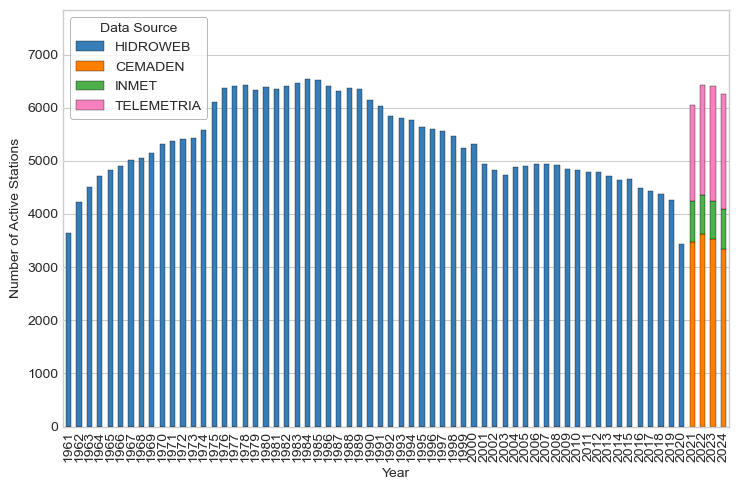

In [ ]:
# Group by year and source, and count the number of unique gauge_codes
df_active_gauges = df_complete_info_by_year.groupby(['year', 'source']).agg({'gauge_code': 'nunique'}).reset_index()

# Pivot the dataframe to have years as index and sources as columns
df_pivot = df_active_gauges.pivot(index='year', columns='source', values='gauge_code').fillna(0)
df_pivot = df_pivot[['HIDROWEB', 'CEMADEN', 'INMET', 'TELEMETRIA']]
# df_pivot.replace(0, np.nan, inplace=True)

ax = df_pivot.plot(kind='bar'
                   , stacked=True
                   , figsize=(7.5, 5)
                   , color=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf']
                   , edgecolor = 'black'
                   , linewidth = 0.25)

# Modify the EXISTING legend from pandas plot
legend = ax.get_legend()
legend.set_title('Data Source')  # Set title
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

# Rest of your plot code
plt.ylim(0, df_active_gauges['gauge_code'].max() * 1.2)
plt.xlabel('Year')
plt.ylabel('Number of Active Stations')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./figures/active_stations_per_year.tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

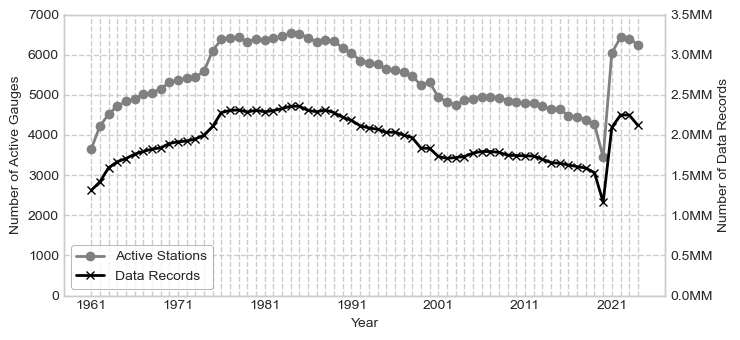

In [14]:
def millions_formatter(x, pos):
    return f'{round(x/1e6,2)}MM'

# Grouping data
stations_per_year = df_complete_info_by_year.groupby('year')['gauge_code'].nunique().reset_index(name='active_stations')
records_per_year = df_complete_info_by_year.groupby('year')['num_days_activity'].sum().reset_index(name='record_count')

# Ensure years are sorted
stations_per_year.sort_values('year', inplace=True)
records_per_year.sort_values('year', inplace=True)

# Set x-tick labels
years = list(range(1961, 2025, 1))  # Years from 1961 to 2024
xticks = years  # Use all years as x-ticks
xticklabels = [str(year) if str(year).endswith('1') else '' for year in years]  # Labels only for years ending in "1"

fig, ax1 = plt.subplots(figsize=(7.5, 3.5))

# Plot active stations
ax1.plot(stations_per_year['year'], stations_per_year['active_stations'], color='grey', marker='o', label='Active Stations', linewidth=2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, rotation=0)
ax1.set_ylim(0, 7000)
ax1.grid(linestyle='--', linewidth=1, axis='both')

# Secondary axis for data records
ax2 = ax1.twinx()
ax2.plot(records_per_year['year'], records_per_year['record_count'], color='black', marker='x', label='Data Records', linewidth=2)
ax2.set_ylim(0, 3500000)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Axis labels
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Active Gauges')
ax2.set_ylabel('Number of Data Records')

# Title
# plt.title("Number of Active Stations and Data Records by Year", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Modify the EXISTING legend from pandas plot
legend.set_frame_on(True)  # Ensure frame is visible

# Customize frame properties
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')
frame.set_linewidth(0.5)

plt.tight_layout()

# Save the figure
plt.savefig('./figures/stations_and_records_by_year_1961_2024.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()